In [24]:
import sys
import inspect
from importlib import reload
from tqdm import tqdm

import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.constants import pi, c, epsilon_0, mu_0

rcParams['figure.figsize'] = (8,6)
rcParams['font.size'] = 20

import quvac
from quvac.paraxial_gaussian import ParaxialGaussianAnalytic
from quvac.field import ExternalField
from quvac.vacuum_emission import VacuumEmission

## Test: two paraxial gaussians for different collision angles

In [25]:
tau = 25e-15
W = 25
lam = 0.8e-6
w0 = 1*lam
thetas = np.linspace(0,180,19)

field_1 = {
    "field_type": "paraxial_gaussian_analytic",
    "focus_x": (0.,0.,0.),
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 90,
    "lmbd": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

field_2 = {
    "field_type": "paraxial_gaussian_analytic",
    "focus_x": (0.,0.,0.),
    "focus_t": 0.,
    "theta": 180,
    "phi": 0,
    "beta": 90,
    "lmbd": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

fields_params = [field_1, field_2]

x0 = 4*w0
x = np.linspace(-x0,x0,32).reshape((-1,1,1))
y0 = 4*w0
y = np.linspace(-y0,y0,32).reshape((1,-1,1))
z0 = 10*w0
z = np.linspace(-z0,z0,256).reshape((1,1,-1))
grid = (x, y, z)

t_grid = np.linspace(-2*tau, 2*tau, 301)

In [26]:
Ntots = np.zeros_like(thetas)

In [27]:
for i,theta in enumerate(tqdm(thetas)):
    field_2['theta'] = float(theta)
    fields_params = [field_1, field_2]
    
    field = ExternalField(fields_params, grid)
    vacem = VacuumEmission(field)
    vacem.calculate_vacuum_current(t_grid)
    Ntot = vacem.calculate_total_signal()
    Ntots[i] = Ntot

19it [06:40, 21.08s/it]


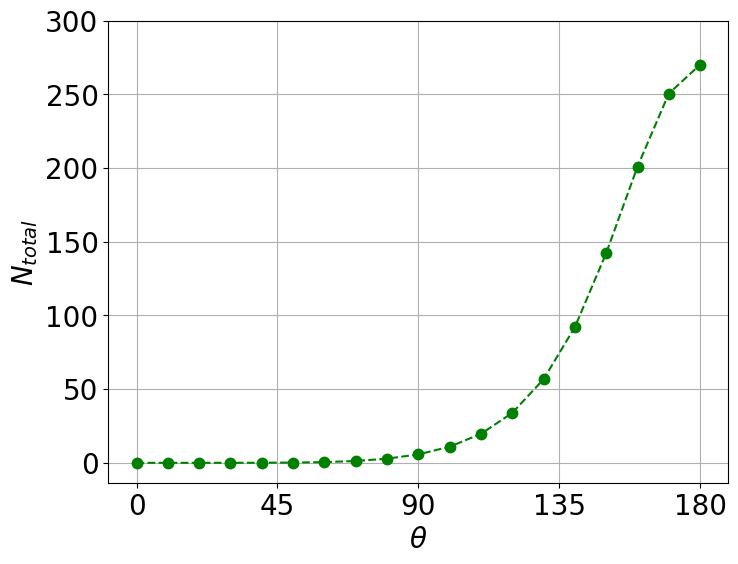

In [29]:
plt.figure()
plt.plot(thetas, Ntots, '.--', color='green', ms=15)
plt.grid()
plt.xlabel('$\\theta$')
plt.ylabel('$N_{total}$')
plt.xticks([45*i for i in range(5)])
plt.yticks([50*i for i in range(7)])
plt.savefig('../imgs/tests/2_paraxial_Ntot_theta.png')
plt.show()